# Import

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transfroms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import os

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms, datasets
from PIL import Image
from torchvision.datasets import ImageFolder
from sklearn.manifold import TSNE
from matplotlib.pyplot import style
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset

# original shape of Dataset

In [35]:
transform = transforms.Compose([
    transforms.ToTensor(),                       # image -> PyTorch tensor
])

train_dataset = ImageFolder(root = './data/train-50', transform = transform)
train_loader = DataLoader(train_dataset, batch_size = len(train_dataset), shuffle = False)

for images, labels in train_loader:
    x_train = images
    y_train = labels

In [36]:
x_train.shape

torch.Size([500, 3, 28, 28])

# final shape of Dataset

### augmentation

In [37]:
aug_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.Resize((32, 32)),
    transforms.RandomCrop((28, 28)),
    transforms.ToTensor()
])

x_train_aug = []
y_train_aug = []

for _ in range(10):
    aug_dataset = ImageFolder(root = './data/train-50', transform = aug_transform)
    aug_loader = DataLoader(aug_dataset, batch_size = len(aug_dataset), shuffle = False)
    for images, labels in aug_loader:
        x_train_aug.extend(images)
        y_train_aug.extend(labels)
x_train_aug = torch.stack(x_train_aug)
y_train_aug = torch.tensor(y_train_aug)

x_train = torch.cat((x_train, x_train_aug), dim=0)
y_train = torch.cat((y_train, y_train_aug), dim=0)

# Augmented image visualization

In [38]:
def imshow(tensor):
    np_img = tensor.numpy()
    plt.imshow(np_img[0], cmap = 'gray')

In [39]:
print(x_train.shape)

torch.Size([5500, 3, 28, 28])


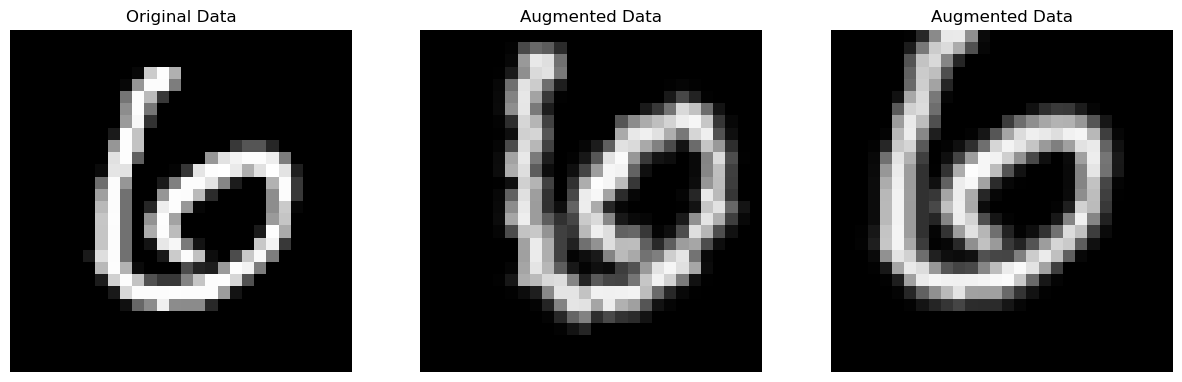

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 첫 번째 이미지 시각화
axes[0].imshow(x_train[300].permute(1, 2, 0))  # 차원 재정렬
axes[0].set_title("Original Data")
axes[0].axis('off')

# 두 번째 이미지 시각화
axes[1].imshow(x_train[800].permute(1, 2, 0))  # 차원 재정렬
axes[1].set_title("Augmented Data")
axes[1].axis('off')

# 세 번째 이미지 시각화
axes[2].imshow(x_train[1300].permute(1, 2, 0))  # 차원 재정렬
axes[2].set_title("Augmented Data")
axes[2].axis('off')

plt.show()

# Augmented Image in feature space

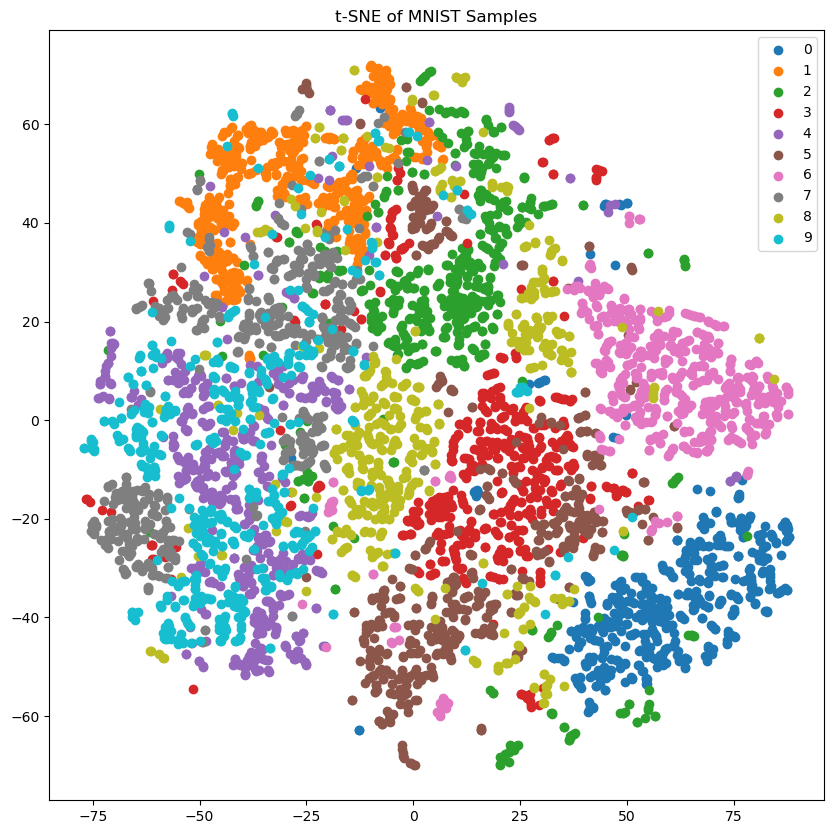

In [41]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE Visualization
sample_indices = np.random.choice(len(x_train), len(x_train), replace=False)  # 샘플 크기를 500으로 조정
sample_images = np.array([x_train[i].numpy().reshape(-1) for i in sample_indices])
sample_labels = np.array([y_train[i] for i in sample_indices])

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(sample_images)

plt.figure(figsize=(10, 10))
for i in range(10):
    indices = sample_labels == i
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=str(i))
plt.legend()
plt.title('t-SNE of MNIST Samples')
plt.show()


# Utility Class & Function

In [42]:
def imshow(tensor):
    np_img = tensor.numpy()
    plt.imshow(np_img[0], cmap = 'gray')

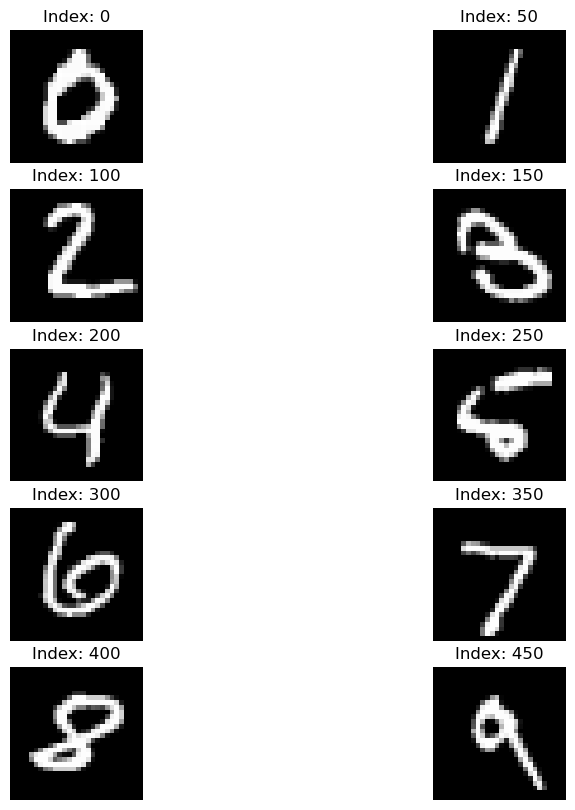

In [43]:
plt.figure(figsize=(10, 10))
indices = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450]  # indices of images

for i, idx in enumerate(indices):
    plt.subplot(5, 2, i+1) 
    imshow(x_train[idx]) 
    plt.title(f'Index: {idx}')  
    plt.axis('off') 

plt.show()

In [44]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Source:
            https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'> early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# SimCLR

### augmentation for self-supervised learning

In [45]:
def crop_and_rotate(image):
    image = image.clone().detach()
    x_stpoint = np.random.randint(20)
    y_stpoint = np.random.randint(20)

    image[..., x_stpoint : x_stpoint + 9, y_stpoint : y_stpoint + 9] = 0.5 
    return torch.rot90(image, 1, [-2, -1])

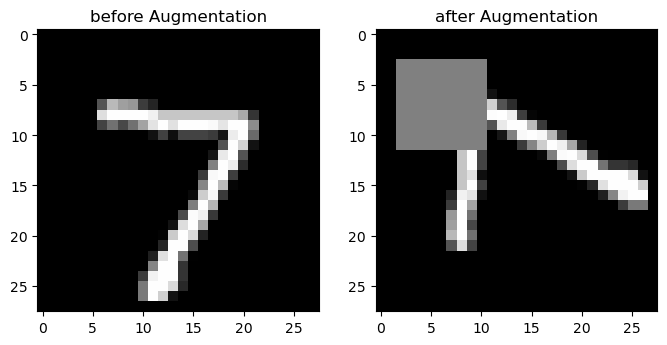

In [46]:
original_img = x_train[350].clone().detach().cpu()

# 변환된 이미지
augmented_img = crop_and_rotate(original_img)

# 이미지 시각화
plt.figure(figsize=(8, 4))  # 전체 그림판 크기 설정

# 원본 이미지 시각화
plt.subplot(1, 2, 1)
imshow(original_img)
plt.title('before Augmentation')

# 변환된 이미지 시각화
plt.subplot(1, 2, 2)
imshow(augmented_img)
plt.title('after Augmentation')

plt.show()

# Encoder : ResNet50 architecture

In [47]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # load ResNet50 architecture
        self.resnet = models.resnet50(weights = None)
        
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 1024)

    def forward(self, x):
        return self.resnet(x)

# Encoder + ProjectionHead

### Pretext Task : Self-Supervised Learning (pre-train)

In [48]:
class Enc_PH(nn.Module):
    def __init__(self, model, feat_dim=128):
        super(Enc_PH, self).__init__()
        
        self.dim_in = model.resnet.fc.out_features
        self.encoder = model
        
        self.head = nn.Sequential(
            nn.Linear(self.dim_in, self.dim_in),
            nn.ReLU(inplace=True),
            nn.Linear(self.dim_in, feat_dim)
        )

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat

# Encoder + Classifier

### Downstream Task : Classification

In [49]:
class Enc_Classifier(torch.nn.Module):
    """Linear classifier"""
    def __init__(self, model):
        super(Enc_Classifier, self).__init__()
        self.encoder = model.encoder
        self.mlp = nn.Sequential(
                nn.Linear(model.encoder.resnet.fc.out_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.5),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(0.5),
                nn.Linear(128, 10)
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.mlp(x)
        return x

# SimCLR loss function

In [50]:
class SimCLR_loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        
        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction = "sum")
        self.similarity_f = nn.CosineSimilarity(dim = 2)
    
    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size # positive + negative sample
        mask = torch.ones((N, N), dtype = bool)
        
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask
    
    def forward(self, z_i, z_j):
        N = 2 * self.batch_size
        z = torch.cat((z_i, z_j), dim = 0) # 모델의 특징 벡터 z_i와 aug 버전의 z_j 를 합쳐서 z 생성(positive + negative)
        
        # low temperature -> cosine similarity emphasize
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0))/self.temperature 
    
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        return loss

# Split train/val dataset

In [51]:
# TensorDataset 을 생성
dataset = TensorDataset(x_train, y_train)

# dataset[0][] ~ dataset[499][]
# dataset[0][0] : tensor
# dataset[0][1] : label

# train - validation size 분할
total_size = len(dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size

# 데이터 셋 분할
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloader 생성
train_loader = DataLoader(train_dataset, batch_size = train_size, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = val_size, shuffle = False)

# train, val data 불러오기
for images, labels in train_loader:
    x_train = images
    y_train = labels

for images, labels in val_loader:
    x_val = images
    y_val = labels

In [52]:
x_train.shape

torch.Size([4400, 3, 28, 28])

# Pretext Task : Contrastive Learning(SSL, pretrain)

In [63]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_aug1 = crop_and_rotate(x_train).to(DEVICE)
x_train_aug2 = crop_and_rotate(x_train).to(DEVICE)

dataset = TensorDataset(x_train_aug1, x_train_aug2)
batch_size = 100

dataloader = DataLoader(dataset, batch_size = batch_size)

encoder = Encoder()
model = Enc_PH(encoder, feat_dim=128)

loss_func = SimCLR_loss(batch_size, temperature = 0.03)

epoch = 20
model.to(DEVICE)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for i in range(1, epoch + 1):
    total_loss = 0.0
    for data in tqdm(dataloader):
        aug_data_1 = data[0].to(DEVICE)
        aug_data_2 = data[1].to(DEVICE)
        
        aug_vec_1 = model(aug_data_1)
        aug_vec_2 = model(aug_data_2)
        
        loss = loss_func(aug_vec_1, aug_vec_2)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    print("EPOCH : %d, AVG LOSS : %.4f"%(i, total_loss / len(dataloader)))

  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 1, AVG LOSS : 4.0569


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 2, AVG LOSS : 1.4166


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 3, AVG LOSS : 0.5607


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 4, AVG LOSS : 0.2821


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 5, AVG LOSS : 0.1468


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 6, AVG LOSS : 0.0854


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 7, AVG LOSS : 0.0703


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 8, AVG LOSS : 0.0501


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 9, AVG LOSS : 0.0335


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 10, AVG LOSS : 0.0190


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 11, AVG LOSS : 0.0242


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 12, AVG LOSS : 0.0183


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 13, AVG LOSS : 0.0200


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 14, AVG LOSS : 0.0118


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 15, AVG LOSS : 0.0138


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 16, AVG LOSS : 0.0082


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 17, AVG LOSS : 0.0112


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 18, AVG LOSS : 0.0035


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 19, AVG LOSS : 0.0010


  0%|          | 0/44 [00:00<?, ?it/s]

EPOCH : 20, AVG LOSS : 0.0004


# Fine tuning the model, suitable for downstream task

In [64]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_epoch = -1

class_dataset = TensorDataset(x_train, y_train)
batch_size = 50

class_dataloader = DataLoader(class_dataset, batch_size = batch_size)


classifier = Enc_Classifier(model).to(DEVICE)

classifier_loss = nn.CrossEntropyLoss()

epoch = 100
optimizer = torch.optim.Adam(classifier.parameters(), lr = 1e-4)

early_stopping = EarlyStopping(patience=10, verbose=False, delta=1e-4)

for i in range(1, epoch + 1):
    train_loss = 0.0
    correct = 0
    
    classifier.train()
    
    for data in tqdm(class_dataloader):
        input_data = data[0].to(DEVICE)
        label_data = data[1].to(DEVICE)

        logits = classifier(input_data)
        loss = classifier_loss(logits, label_data.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += torch.sum(torch.argmax(logits, 1) == label_data).item()
    train_accuracy = correct/len(train_dataset)*100
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss/len(train_dataset))
    
    classifier.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data in val_loader:
            input_data = data[0].to(DEVICE)
            label_data = data[1].to(DEVICE)
            
            logits = classifier(input_data)
            val_loss += loss.item()
            correct += torch.sum(torch.argmax(logits, 1) == label_data).item()
            
    val_accuracy = correct/len(val_dataset) * 100
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss/len(val_dataset))

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print('Early stopping at epoch', epoch)
        break
        
    print(f"EPOCH : {i}, TRAIN ACCURACY : {train_accuracy:.2f}, VAL ACCURACY : {val_accuracy:.2f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = i
        torch.save(model, './checkpoint/finest_model.pth')


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 1, TRAIN ACCURACY : 29.00, VAL ACCURACY : 48.36


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 2, TRAIN ACCURACY : 57.07, VAL ACCURACY : 76.82


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 3, TRAIN ACCURACY : 84.25, VAL ACCURACY : 90.45


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 4, TRAIN ACCURACY : 94.30, VAL ACCURACY : 92.27


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 5, TRAIN ACCURACY : 96.59, VAL ACCURACY : 94.45


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 6, TRAIN ACCURACY : 98.59, VAL ACCURACY : 94.18


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 7, TRAIN ACCURACY : 99.00, VAL ACCURACY : 93.91


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 8, TRAIN ACCURACY : 98.89, VAL ACCURACY : 94.00


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 9, TRAIN ACCURACY : 98.52, VAL ACCURACY : 94.27


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 10, TRAIN ACCURACY : 98.36, VAL ACCURACY : 92.09


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 11, TRAIN ACCURACY : 98.86, VAL ACCURACY : 95.91


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 12, TRAIN ACCURACY : 98.95, VAL ACCURACY : 95.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 13, TRAIN ACCURACY : 99.27, VAL ACCURACY : 95.64


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 14, TRAIN ACCURACY : 99.75, VAL ACCURACY : 96.73


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 15, TRAIN ACCURACY : 99.89, VAL ACCURACY : 95.55


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 16, TRAIN ACCURACY : 99.34, VAL ACCURACY : 96.73


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 17, TRAIN ACCURACY : 99.50, VAL ACCURACY : 95.82


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 18, TRAIN ACCURACY : 99.36, VAL ACCURACY : 95.27


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 19, TRAIN ACCURACY : 99.43, VAL ACCURACY : 96.27


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 20, TRAIN ACCURACY : 99.07, VAL ACCURACY : 97.36


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 21, TRAIN ACCURACY : 99.36, VAL ACCURACY : 97.64


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 22, TRAIN ACCURACY : 99.50, VAL ACCURACY : 97.36


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 23, TRAIN ACCURACY : 99.11, VAL ACCURACY : 95.73


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 24, TRAIN ACCURACY : 99.32, VAL ACCURACY : 96.55


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 25, TRAIN ACCURACY : 99.66, VAL ACCURACY : 97.73


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 26, TRAIN ACCURACY : 99.82, VAL ACCURACY : 96.91


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 27, TRAIN ACCURACY : 99.77, VAL ACCURACY : 97.73


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 28, TRAIN ACCURACY : 99.93, VAL ACCURACY : 97.18


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 29, TRAIN ACCURACY : 99.98, VAL ACCURACY : 97.82


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 30, TRAIN ACCURACY : 100.00, VAL ACCURACY : 97.91


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 31, TRAIN ACCURACY : 100.00, VAL ACCURACY : 97.91


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 32, TRAIN ACCURACY : 100.00, VAL ACCURACY : 97.91


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 33, TRAIN ACCURACY : 100.00, VAL ACCURACY : 97.91


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 3 out of 10
EPOCH : 34, TRAIN ACCURACY : 100.00, VAL ACCURACY : 97.91


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 35, TRAIN ACCURACY : 100.00, VAL ACCURACY : 97.91


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 36, TRAIN ACCURACY : 100.00, VAL ACCURACY : 97.91


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 37, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.09


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 3 out of 10
EPOCH : 38, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.09


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 4 out of 10
EPOCH : 39, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.09


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 5 out of 10
EPOCH : 40, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 6 out of 10
EPOCH : 41, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 7 out of 10
EPOCH : 42, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 8 out of 10
EPOCH : 43, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 44, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 45, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 46, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 47, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 48, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 49, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 50, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 51, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.09


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 52, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.09


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 3 out of 10
EPOCH : 53, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.09


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 54, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 55, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 56, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.09


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 3 out of 10
EPOCH : 57, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.09


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 4 out of 10
EPOCH : 58, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 5 out of 10
EPOCH : 59, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.27


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 6 out of 10
EPOCH : 60, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.09


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 61, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.36


  0%|          | 0/88 [00:00<?, ?it/s]

EPOCH : 62, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.36


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 1 out of 10
EPOCH : 63, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.36


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 2 out of 10
EPOCH : 64, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.27


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 3 out of 10
EPOCH : 65, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.27


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 4 out of 10
EPOCH : 66, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.27


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 5 out of 10
EPOCH : 67, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.36


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 6 out of 10
EPOCH : 68, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 7 out of 10
EPOCH : 69, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.27


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 8 out of 10
EPOCH : 70, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.18


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 9 out of 10
EPOCH : 71, TRAIN ACCURACY : 100.00, VAL ACCURACY : 98.27


  0%|          | 0/88 [00:00<?, ?it/s]

> early stopping counter: 10 out of 10
Early stopping at epoch 100


# Train & Validation Accuracy

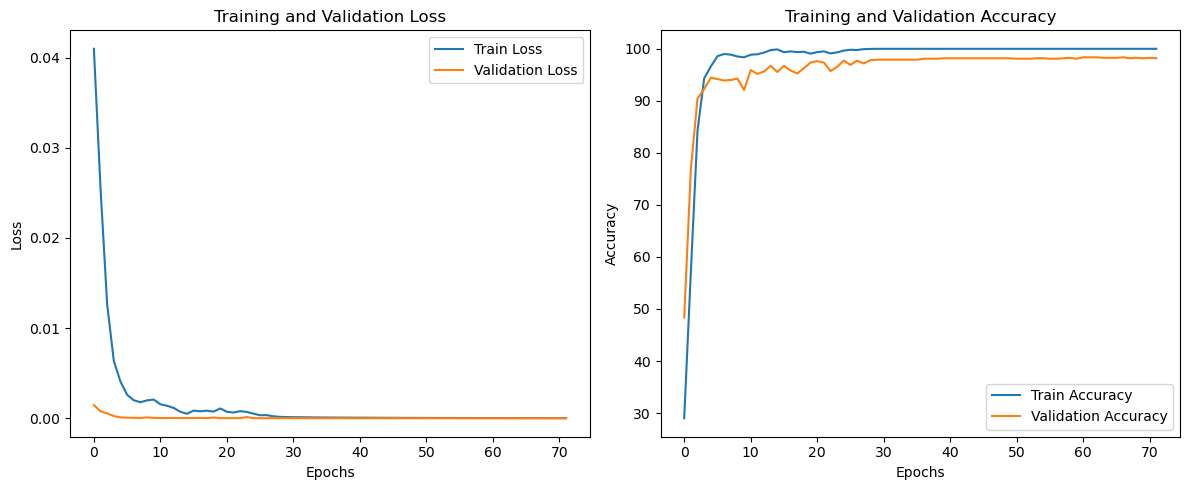

In [65]:
plt.figure(figsize=(12, 5))

# Loss 
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Model 불러오기 (가장 성능 좋은 모델)

In [70]:
model = torch.load('./checkpoint/finest_model.pth')

# Test the finest model

In [71]:
def plot_scatter(x_test,y_test):
    scatter_x = x_test[:, 0]
    scatter_y = x_test[:, 1]
    

    fig, ax = plt.subplots()
    for g in np.unique(y_test):
        ix = np.where(y_test == g)
        ax.scatter(scatter_x[ix], scatter_y[ix],  label = g, s = 10)
    plt.legend()


In [72]:
def plot_features(model, device, data_loader):
    model.to(device)
    feature_space = []
    labels = []
    with torch.no_grad():
        for (imgs, label) in tqdm(data_loader, desc='feature extracting'):
            imgs = imgs.to(device)
            features = model(imgs)
            feature_space.append(features)
            labels.append(label)
        feature_space = torch.cat(feature_space, dim=0).contiguous().cpu().numpy()
        labels = torch.cat(labels, dim=0).cpu().numpy()
    X_reduced_test = TSNE(n_components=2, random_state=0).fit_transform(feature_space)
    plot_scatter(X_reduced_test,labels)

feature extracting:   0%|          | 0/1 [00:00<?, ?it/s]

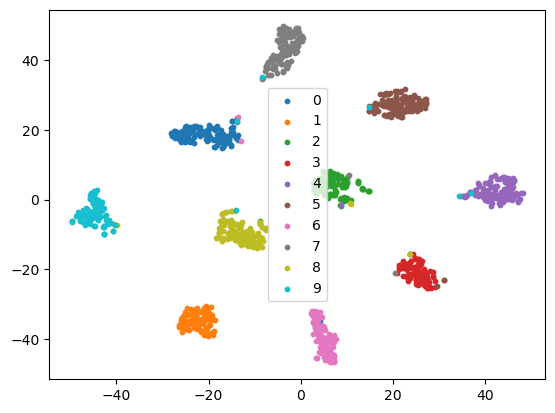

In [73]:
plot_features(model, DEVICE, val_loader)